### SHAP Feature Group Comparison
This notebook is used for comparing the SHAP visualisation/sensitivity curve of the different featrue groups with the original imbalance factor because with oversampling the SHAP would also analyse importance with the synthetic samples, which could be hugely biased due to original data distribution. <br>

This is also more cost-efficient compared to the oversampling and repetition pipeline because it only depends on the first models built from the original dataset. Therefore, we decide to put this as the second step of the three-step pipeline for feature evaluation. 

In [27]:
import pickle
import shap
import matplotlib.pyplot as plt
import pandas as pd

shap.initjs()

In [95]:
# Group A
DATA_PATH = "../results/plco/correct_pipeline/smote_xgb/shap_original_A"

ratio = 7

repo = DATA_PATH+f"/test/"

file_name = repo+"smote_xgb_0_special.pkl"

with open(file_name, "rb") as f:
    result = pickle.load(f)
    model_train_x_a = result["x_train"]
    y_train_true_a = result["y_train"]
with open(repo+f"smote_xgb_{0}_special_clf.pkl", "rb") as f:
    model_a = pickle.load(f)

In [39]:
explainer_a = shap.Explainer(model_a)
shap_values_a = explainer_a(model_train_x_a)[:, :]

# shap.plots.beeswarm(shap_values_a, max_display=100, show=False)
# fig, ax = plt.gcf(), plt.gca()

# ax.set_ylabel("Variable value")

# # plt.savefig("./globalshap.png")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [40]:
shap.plots.force(shap_values_a)

In [97]:
# Group B
DATA_PATH = "../results/plco/correct_pipeline/smote_xgb/shap_original_B"

ratio = 7

repo = DATA_PATH+f"/test/"

file_name = repo+"smote_xgb_0_special.pkl"

with open(file_name, "rb") as f:
    result = pickle.load(f)
    model_train_x_b = result["x_train"]
    y_train_true_b = result["y_train"]
with open(repo+f"smote_xgb_{0}_special_clf.pkl", "rb") as f:
    model_b = pickle.load(f)

In [98]:
explainer_b = shap.Explainer(model_b)
shap_values_b = explainer_b(model_train_x_b)[:, :]

# shap.plots.beeswarm(shap_values_b, max_display=100, show=False)
# fig, ax = plt.gcf(), plt.gca()

# ax.set_ylabel("Variable value")

# # plt.savefig("./globalshap.png")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [99]:
shap.plots.force(shap_values_b)

In [111]:
shap_sum_a = pd.DataFrame([shap_values_a.values.sum(axis=1), y_train_true_a]).T.set_index(model_train_x_a.index)
shap_sum_a.columns = ["shap_val", "y_true"]
shap_sum_a = shap_sum_a.sort_values("shap_val")

shap_sum_b = pd.DataFrame([shap_values_b.values.sum(axis=1), y_train_true_b]).T.set_index(model_train_x_b.index)
shap_sum_b.columns = ["shap_val", "y_true"]
shap_sum_b = shap_sum_b.sort_values("shap_val")


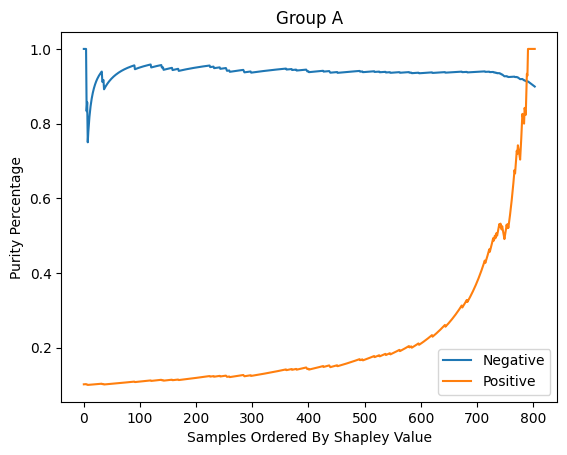

In [167]:
# Group A
neg_purities = []
pos_purities = []

for i in range(0, len(shap_sum_a.index)-1):
    pred_neg = shap_sum_a["y_true"].iloc[0:i+1]
    pred_pos = shap_sum_a["y_true"].iloc[i+1:]

    neg_purity = 1 - sum(pred_neg)/len(pred_neg)
    pos_purity = sum(pred_pos)/len(pred_pos)
    
    neg_purities.append(neg_purity)
    pos_purities.append(pos_purity)

plt.plot(neg_purities, label="Negative")
plt.plot(pos_purities, label="Positive")
plt.xlabel("Samples Ordered By Shapley Value")
plt.ylabel("Purity Percentage")
plt.title("Group A")
plt.legend()
plt.show()

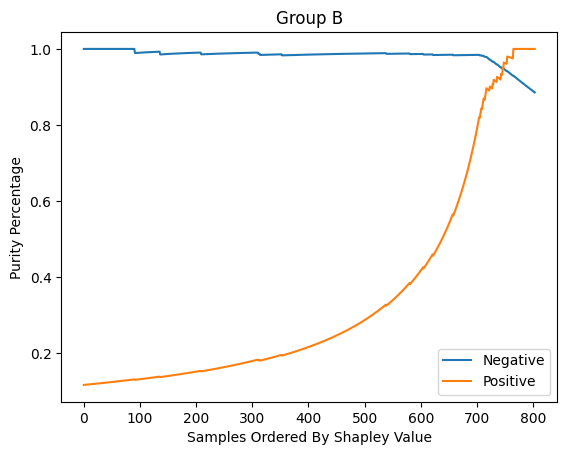

In [168]:
# Group B
neg_purities = []
pos_purities = []

for i in range(0, len(shap_sum_a.index)-1):
    pred_neg = shap_sum_b["y_true"].iloc[0:i+1]
    pred_pos = shap_sum_b["y_true"].iloc[i+1:]

    neg_purity = 1 - sum(pred_neg)/len(pred_neg)
    pos_purity = sum(pred_pos)/len(pred_pos)
    
    neg_purities.append(neg_purity)
    pos_purities.append(pos_purity)

plt.plot(neg_purities, label="Negative")
plt.plot(pos_purities, label="Positive")
plt.xlabel("Samples Ordered By Shapley Value")
plt.ylabel("Purity Percentage")
plt.title("Group B")
plt.legend()
plt.show()

---

### Analysis
In general, there are a few properties to look at in these figures: 
1. Abrupt value changes: Group A has shown an abrupt change in the negative curve, meaning there were some major false negative samples by simply ranking the Shapley values
2. Smoothness of curve: There was a few observable up and downs on the Group A negative curve, meaning there were some minor false negatives at those places. Similar trends could be observed from the positive curves in both figures towards the end of x-axis, meaning there were some minor false positives
3. Slope: Group A has a more steep positive curve compared to Group B, especially towards the end of x-axis. This means the Shapley value changes have brought a more significant change into the classification here, meaning the features in Group A might be more prominent compared to Group B. 

If one of the figures has shown significant worse results compared to the other, meaning it has more abrupt changes of larger values, many non-smooth trends, and a less steep slope, then the one with better result has a higher probability of having more significant features. 

### Conclusion on These Two Figures
Although Group B has less abrupt changes and more smooth curves, the curve is less steep compared to Group A. This means it is still possible that Group A features have a more significant effect on this classification. Therefore, it is more reliable to carry out the third step of feature evaluation. 